# Implementing logistic regression from scratch

The goal of this notebook is to implement your own logistic regression classifier. You will:

 * Extract features from Amazon product reviews.
 * Convert an SFrame into a NumPy array.
 * Implement the link function for logistic regression.
 * Write a function to compute the derivative of the log likelihood function with respect to a single coefficient.
 * Implement gradient ascent.
 * Given a set of coefficients, predict sentiments.
 * Compute classification accuracy for the logistic regression model.
 
Let's get started!
    
## Fire up GraphLab Create

Make sure you have the latest version of GraphLab Create. Upgrade by
```
   pip install graphlab-create --upgrade
```
See [this page](https://dato.com/download/) for detailed instructions on upgrading.

In [1]:
import graphlab

## Load review dataset

For this assignment, we will use a subset of the Amazon product review dataset. The subset was chosen to contain similar numbers of positive and negative reviews, as the original dataset consisted primarily of positive reviews.

In [2]:
products = graphlab.SFrame('amazon_baby_subset.gl/')

This non-commercial license of GraphLab Create for academic use is assigned to prafullitsukhwant@gmail.com and will expire on August 24, 2018.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1519875056.log


In [4]:
products

name,review,rating,sentiment
Stop Pacifier Suckingwithout tears with ...,All of my kids have criednon-stop when I tried to ...,5.0,1
Nature's Lullabies SecondYear Sticker Calendar ...,We wanted to getsomething to keep track ...,5.0,1
Nature's Lullabies SecondYear Sticker Calendar ...,My daughter had her 1stbaby over a year ago. ...,5.0,1
"Lamaze Peekaboo, I LoveYou ...","One of baby's first andfavorite books, and i ...",4.0,1
SoftPlay Peek-A-BooWhere's Elmo A Childr ...,Very cute interactivebook! My son loves this ...,5.0,1
Our Baby Girl Memory Book,"Beautiful book, I love itto record cherished t ...",5.0,1
Hunnt&reg; FallingFlowers and Birds Kids ...,"Try this out for a springproject !Easy ,fun and ...",5.0,1
Blessed By Pope BenedictXVI Divine Mercy Full ...,very nice Divine MercyPendant of Jesus now on ...,5.0,1
Cloth Diaper PinsStainless Steel ...,We bought the pins as my6 year old Autistic son ...,4.0,1
Cloth Diaper PinsStainless Steel ...,It has been many yearssince we needed diaper ...,5.0,1


One column of this dataset is 'sentiment', corresponding to the class label with +1 indicating a review with positive sentiment and -1 indicating one with negative sentiment.

In [3]:
products['sentiment']

dtype: int
Rows: 53072
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... ]

Let us quickly explore more of this dataset.  The 'name' column indicates the name of the product.  Here we list the first 10 products in the dataset.  We then count the number of positive and negative reviews.

In [5]:
products.head(10)['name']

dtype: str
Rows: 10
["Stop Pacifier Sucking without tears with Thumbuddy To Love's Binky Fairy Puppet and Adorable Book", "Nature's Lullabies Second Year Sticker Calendar", "Nature's Lullabies Second Year Sticker Calendar", 'Lamaze Peekaboo, I Love You', "SoftPlay Peek-A-Boo Where's Elmo A Children's Book", 'Our Baby Girl Memory Book', 'Hunnt&reg; Falling Flowers and Birds Kids Nursery Home Decor Vinyl Mural Art Wall Paper Stickers', 'Blessed By Pope Benedict XVI Divine Mercy Full Color Medal', 'Cloth Diaper Pins Stainless Steel Traditional Safety Pin (Black)', 'Cloth Diaper Pins Stainless Steel Traditional Safety Pin (Black)']

In [6]:
print '# of positive reviews =', len(products[products['sentiment']==1])
print '# of negative reviews =', len(products[products['sentiment']==-1])

# of positive reviews = 26579
# of negative reviews = 26493


**Note:** For this assignment, we eliminated class imbalance by choosing 
a subset of the data with a similar number of positive and negative reviews. 

## Apply text cleaning on the review data

In this section, we will perform some simple feature cleaning using **SFrames**. The last assignment used all words in building bag-of-words features, but here we limit ourselves to 193 words (for simplicity). We compiled a list of 193 most frequent words into a JSON file. 

Now, we will load these words from this JSON file:

In [7]:
import json
with open('important_words.json', 'r') as f: # Reads the list of most frequent words
    important_words = json.load(f)
important_words = [str(s) for s in important_words]

In [8]:
print important_words

['baby', 'one', 'great', 'love', 'use', 'would', 'like', 'easy', 'little', 'seat', 'old', 'well', 'get', 'also', 'really', 'son', 'time', 'bought', 'product', 'good', 'daughter', 'much', 'loves', 'stroller', 'put', 'months', 'car', 'still', 'back', 'used', 'recommend', 'first', 'even', 'perfect', 'nice', 'bag', 'two', 'using', 'got', 'fit', 'around', 'diaper', 'enough', 'month', 'price', 'go', 'could', 'soft', 'since', 'buy', 'room', 'works', 'made', 'child', 'keep', 'size', 'small', 'need', 'year', 'big', 'make', 'take', 'easily', 'think', 'crib', 'clean', 'way', 'quality', 'thing', 'better', 'without', 'set', 'new', 'every', 'cute', 'best', 'bottles', 'work', 'purchased', 'right', 'lot', 'side', 'happy', 'comfortable', 'toy', 'able', 'kids', 'bit', 'night', 'long', 'fits', 'see', 'us', 'another', 'play', 'day', 'money', 'monitor', 'tried', 'thought', 'never', 'item', 'hard', 'plastic', 'however', 'disappointed', 'reviews', 'something', 'going', 'pump', 'bottle', 'cup', 'waste', 'retu

Now, we will perform 2 simple data transformations:

1. Remove punctuation using [Python's built-in](https://docs.python.org/2/library/string.html) string functionality.
2. Compute word counts (only for **important_words**)

We start with *Step 1* which can be done as follows:

In [9]:
def remove_punctuation(text):
    import string
    return text.translate(None, string.punctuation) 

products['review_clean'] = products['review'].apply(remove_punctuation)

Now we proceed with *Step 2*. For each word in **important_words**, we compute a count for the number of times the word occurs in the review. We will store this count in a separate column (one for each word). The result of this feature processing is a single column for each word in **important_words** which keeps a count of the number of times the respective word occurs in the review text.


**Note:** There are several ways of doing this. In this assignment, we use the built-in *count* function for Python lists. Each review string is first split into individual words and the number of occurances of a given word is counted.

In [10]:
for word in important_words:
    products[word] = products['review_clean'].apply(lambda s : s.split().count(word))

The SFrame **products** now contains one column for each of the 193 **important_words**. As an example, the column **perfect** contains a count of the number of times the word **perfect** occurs in each of the reviews.

In [11]:
products['perfect']

dtype: int
Rows: 53072
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ... ]

In [13]:
products

name,review,rating,sentiment,review_clean,baby
Stop Pacifier Suckingwithout tears with ...,All of my kids have criednon-stop when I tried to ...,5.0,1,All of my kids have criednonstop when I tried to ...,0
Nature's Lullabies SecondYear Sticker Calendar ...,We wanted to getsomething to keep track ...,5.0,1,We wanted to getsomething to keep track ...,0
Nature's Lullabies SecondYear Sticker Calendar ...,My daughter had her 1stbaby over a year ago. ...,5.0,1,My daughter had her 1stbaby over a year ago She ...,1
"Lamaze Peekaboo, I LoveYou ...","One of baby's first andfavorite books, and i ...",4.0,1,One of babys first andfavorite books and it is ...,0
SoftPlay Peek-A-BooWhere's Elmo A Childr ...,Very cute interactivebook! My son loves this ...,5.0,1,Very cute interactivebook My son loves this ...,0
Our Baby Girl Memory Book,"Beautiful book, I love itto record cherished t ...",5.0,1,Beautiful book I love itto record cherished t ...,0
Hunnt&reg; FallingFlowers and Birds Kids ...,"Try this out for a springproject !Easy ,fun and ...",5.0,1,Try this out for a springproject Easy fun and ...,0
Blessed By Pope BenedictXVI Divine Mercy Full ...,very nice Divine MercyPendant of Jesus now on ...,5.0,1,very nice Divine MercyPendant of Jesus now on ...,0
Cloth Diaper PinsStainless Steel ...,We bought the pins as my6 year old Autistic son ...,4.0,1,We bought the pins as my6 year old Autistic son ...,0
Cloth Diaper PinsStainless Steel ...,It has been many yearssince we needed diaper ...,5.0,1,It has been many yearssince we needed diaper ...,0


Now, write some code to compute the number of product reviews that contain the word **perfect**.

**Hint**: 
* First create a column called `contains_perfect` which is set to 1 if the count of the word **perfect** (stored in column **perfect**) is >= 1.
* Sum the number of 1s in the column `contains_perfect`.

In [15]:
products["contains_perfect"] = products["perfect"] >= 1

In [17]:
products["contains_perfect"].sum()

2955

**Quiz Question**. How many reviews contain the word **perfect**?

## Convert SFrame to NumPy array

As you have seen previously, NumPy is a powerful library for doing matrix manipulation. Let us convert our data to matrices and then implement our algorithms with matrices.

First, make sure you can perform the following import.

In [18]:
import numpy as np

We now provide you with a function that extracts columns from an SFrame and converts them into a NumPy array. Two arrays are returned: one representing features and another representing class labels. Note that the feature matrix includes an additional column 'intercept' to take account of the intercept term.

In [19]:
def get_numpy_data(data_sframe, features, label):
    data_sframe['intercept'] = 1
    features = ['intercept'] + features
    features_sframe = data_sframe[features]
    feature_matrix = features_sframe.to_numpy()
    label_sarray = data_sframe[label]
    label_array = label_sarray.to_numpy()
    return(feature_matrix, label_array)

Let us convert the data into NumPy arrays.

In [20]:
# Warning: This may take a few minutes...
feature_matrix, sentiment = get_numpy_data(products, important_words, 'sentiment') 

In [21]:
feature_matrix

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       ..., 
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [22]:
sentiment

array([ 1,  1,  1, ..., -1, -1, -1])

**Are you running this notebook on an Amazon EC2 t2.micro instance?** (If you are using your own machine, please skip this section)

It has been reported that t2.micro instances do not provide sufficient power to complete the conversion in acceptable amount of time. For interest of time, please refrain from running `get_numpy_data` function. Instead, download the [binary file](https://s3.amazonaws.com/static.dato.com/files/coursera/course-3/numpy-arrays/module-3-assignment-numpy-arrays.npz) containing the four NumPy arrays you'll need for the assignment. To load the arrays, run the following commands:
```
arrays = np.load('module-3-assignment-numpy-arrays.npz')
feature_matrix, sentiment = arrays['feature_matrix'], arrays['sentiment']
```

In [23]:
feature_matrix.shape

(53072, 194)

** Quiz Question:** How many features are there in the **feature_matrix**?

** Quiz Question:** Assuming that the intercept is present, how does the number of features in **feature_matrix** relate to the number of features in the logistic regression model?

Now, let us see what the **sentiment** column looks like:

In [24]:
sentiment

array([ 1,  1,  1, ..., -1, -1, -1])

## Estimating conditional probability with link function

Recall from lecture that the link function is given by:
$$
P(y_i = +1 | \mathbf{x}_i,\mathbf{w}) = \frac{1}{1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))},
$$

where the feature vector $h(\mathbf{x}_i)$ represents the word counts of **important_words** in the review  $\mathbf{x}_i$. Complete the following function that implements the link function:

In [54]:
import math
'''
produces probablistic estimate for P(y_i = +1 | x_i, w).
estimate ranges between 0 and 1.
'''
def predict_probability(feature_matrix, coefficients):
    # Take dot product of feature_matrix and coefficients  
    # YOUR CODE HERE
    dot_product = np.dot(feature_matrix, coefficients)
    
    
    # Compute P(y_i = +1 | x_i, w) using the link function
    # YOUR CODE HERE
    predictions = 1/(1 + np.exp(-1 *dot_product))
    
    # return predictions
    return predictions

**Aside**. How the link function works with matrix algebra

Since the word counts are stored as columns in **feature_matrix**, each $i$-th row of the matrix corresponds to the feature vector $h(\mathbf{x}_i)$:
$$
[\text{feature_matrix}] =
\left[
\begin{array}{c}
h(\mathbf{x}_1)^T \\
h(\mathbf{x}_2)^T \\
\vdots \\
h(\mathbf{x}_N)^T
\end{array}
\right] =
\left[
\begin{array}{cccc}
h_0(\mathbf{x}_1) & h_1(\mathbf{x}_1) & \cdots & h_D(\mathbf{x}_1) \\
h_0(\mathbf{x}_2) & h_1(\mathbf{x}_2) & \cdots & h_D(\mathbf{x}_2) \\
\vdots & \vdots & \ddots & \vdots \\
h_0(\mathbf{x}_N) & h_1(\mathbf{x}_N) & \cdots & h_D(\mathbf{x}_N)
\end{array}
\right]
$$

By the rules of matrix multiplication, the score vector containing elements $\mathbf{w}^T h(\mathbf{x}_i)$ is obtained by multiplying **feature_matrix** and the coefficient vector $\mathbf{w}$.
$$
[\text{score}] =
[\text{feature_matrix}]\mathbf{w} =
\left[
\begin{array}{c}
h(\mathbf{x}_1)^T \\
h(\mathbf{x}_2)^T \\
\vdots \\
h(\mathbf{x}_N)^T
\end{array}
\right]
\mathbf{w}
= \left[
\begin{array}{c}
h(\mathbf{x}_1)^T\mathbf{w} \\
h(\mathbf{x}_2)^T\mathbf{w} \\
\vdots \\
h(\mathbf{x}_N)^T\mathbf{w}
\end{array}
\right]
= \left[
\begin{array}{c}
\mathbf{w}^T h(\mathbf{x}_1) \\
\mathbf{w}^T h(\mathbf{x}_2) \\
\vdots \\
\mathbf{w}^T h(\mathbf{x}_N)
\end{array}
\right]
$$

**Checkpoint**

Just to make sure you are on the right track, we have provided a few examples. If your `predict_probability` function is implemented correctly, then the outputs will match:

In [55]:
dummy_feature_matrix = np.array([[1.,2.,3.], [1.,-1.,-1]])
dummy_coefficients = np.array([1., 3., -1.])

correct_scores      = np.array( [ 1.*1. + 2.*3. + 3.*(-1.),          1.*1. + (-1.)*3. + (-1.)*(-1.) ] )
correct_predictions = np.array( [ 1./(1+np.exp(-correct_scores[0])), 1./(1+np.exp(-correct_scores[1])) ] )

print 'The following outputs must match '
print '------------------------------------------------'
print 'correct_predictions           =', correct_predictions
print 'output of predict_probability =', predict_probability(dummy_feature_matrix, dummy_coefficients)

The following outputs must match 
------------------------------------------------
correct_predictions           = [ 0.98201379  0.26894142]
output of predict_probability = [ 0.98201379  0.26894142]


## Compute derivative of log likelihood with respect to a single coefficient

Recall from lecture:
$$
\frac{\partial\ell}{\partial w_j} = \sum_{i=1}^N h_j(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right)
$$

We will now write a function that computes the derivative of log likelihood with respect to a single coefficient $w_j$. The function accepts two arguments:
* `errors` vector containing $\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})$ for all $i$.
* `feature` vector containing $h_j(\mathbf{x}_i)$  for all $i$. 

Complete the following code block:

In [83]:
def feature_derivative(errors, feature):     
    # Compute the dot product of errors and feature
    derivative = np.dot(feature, errors)
    
    # Return the derivative
    return derivative

In the main lecture, our focus was on the likelihood.  In the advanced optional video, however, we introduced a transformation of this likelihood---called the log likelihood---that simplifies the derivation of the gradient and is more numerically stable.  Due to its numerical stability, we will use the log likelihood instead of the likelihood to assess the algorithm.

The log likelihood is computed using the following formula (see the advanced optional video if you are curious about the derivation of this equation):

$$\ell\ell(\mathbf{w}) = \sum_{i=1}^N \Big( (\mathbf{1}[y_i = +1] - 1)\mathbf{w}^T h(\mathbf{x}_i) - \ln\left(1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))\right) \Big) $$

We provide a function to compute the log likelihood for the entire dataset. 

In [84]:
def compute_log_likelihood(feature_matrix, sentiment, coefficients):
    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    logexp = np.log(1. + np.exp(-scores))
    
    # Simple check to prevent overflow
    mask = np.isinf(logexp)
    logexp[mask] = -scores[mask]
    
    lp = np.sum((indicator-1)*scores - logexp)
    return lp

**Checkpoint**

Just to make sure we are on the same page, run the following code block and check that the outputs match.

In [85]:
dummy_feature_matrix = np.array([[1.,2.,3.], [1.,-1.,-1]])
dummy_coefficients = np.array([1., 3., -1.])
dummy_sentiment = np.array([-1, 1])

correct_indicators  = np.array( [ -1==+1,                                       1==+1 ] )
correct_scores      = np.array( [ 1.*1. + 2.*3. + 3.*(-1.),                     1.*1. + (-1.)*3. + (-1.)*(-1.) ] )
correct_first_term  = np.array( [ (correct_indicators[0]-1)*correct_scores[0],  (correct_indicators[1]-1)*correct_scores[1] ] )
correct_second_term = np.array( [ np.log(1. + np.exp(-correct_scores[0])),      np.log(1. + np.exp(-correct_scores[1])) ] )

correct_ll          =      sum( [ correct_first_term[0]-correct_second_term[0], correct_first_term[1]-correct_second_term[1] ] ) 

print 'The following outputs must match '
print '------------------------------------------------'
print 'correct_log_likelihood           =', correct_ll
print 'output of compute_log_likelihood =', compute_log_likelihood(dummy_feature_matrix, dummy_sentiment, dummy_coefficients)

The following outputs must match 
------------------------------------------------
correct_log_likelihood           = -5.33141161544
output of compute_log_likelihood = -5.33141161544


## Taking gradient steps

Now we are ready to implement our own logistic regression. All we have to do is to write a gradient ascent function that takes gradient steps towards the optimum. 

Complete the following function to solve the logistic regression model using gradient ascent:

In [101]:
from math import sqrt

def logistic_regression(feature_matrix, sentiment, initial_coefficients, step_size, max_iter):
    coefficients = np.array(initial_coefficients) # make sure it's a numpy array
    likelihood = []
    for itr in xrange(max_iter):

        # Predict P(y_i = +1|x_i,w) using your predict_probability() function
        # YOUR CODE HERE
        predictions = predict_probability(feature_matrix, coefficients)
        
        # Compute indicator value for (y_i = +1)
        indicator = (sentiment==+1)
        
        # Compute the errors as indicator - predictions
        errors = indicator - predictions
        for j in xrange(len(coefficients)): # loop over each coefficient
            
            # Recall that feature_matrix[:,j] is the feature column associated with coefficients[j].
            # Compute the derivative for coefficients[j]. Save it in a variable called derivative
            # YOUR CODE HERE
            derivative = feature_derivative(errors, feature_matrix[:,j])
            
            # add the step size times the derivative to the current coefficient
            ## YOUR CODE HERE

            coefficients[j] = coefficients[j] + step_size * derivative
    
        # Checking whether log likelihood is increasing
        if itr <= 15 or (itr <= 100 and itr % 10 == 0) or (itr <= 1000 and itr % 100 == 0) \
        or (itr <= 10000 and itr % 1000 == 0) or itr % 10000 == 0:
            lp = compute_log_likelihood(feature_matrix, sentiment, coefficients)
            print 'iteration %*d: log likelihood of observed labels = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, lp)
            likelihood.append((int(np.ceil(np.log10(max_iter))), itr, lp))
    return coefficients, likelihood

Now, let us run the logistic regression solver.

In [102]:
coefficients, likelihood = logistic_regression(feature_matrix, sentiment, initial_coefficients=np.zeros(194),
                                   step_size=1e-7, max_iter=301)

iteration   0: log likelihood of observed labels = -36780.91768478
iteration   1: log likelihood of observed labels = -36775.13434712
iteration   2: log likelihood of observed labels = -36769.35713564
iteration   3: log likelihood of observed labels = -36763.58603240
iteration   4: log likelihood of observed labels = -36757.82101962
iteration   5: log likelihood of observed labels = -36752.06207964
iteration   6: log likelihood of observed labels = -36746.30919497
iteration   7: log likelihood of observed labels = -36740.56234821
iteration   8: log likelihood of observed labels = -36734.82152213
iteration   9: log likelihood of observed labels = -36729.08669961
iteration  10: log likelihood of observed labels = -36723.35786366
iteration  11: log likelihood of observed labels = -36717.63499744
iteration  12: log likelihood of observed labels = -36711.91808422
iteration  13: log likelihood of observed labels = -36706.20710739
iteration  14: log likelihood of observed labels = -36700.5020

In [103]:
import matplotlib.pyplot as plt
%matplotlib inline

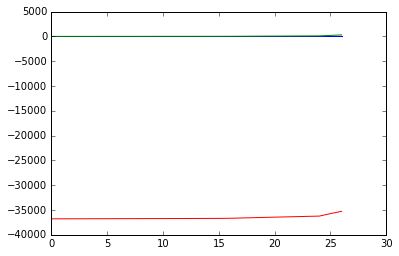

In [104]:
plt.plot(likelihood)

**Quiz Question:** As each iteration of gradient ascent passes, does the log likelihood increase or decrease?

## Predicting sentiments

Recall from lecture that class predictions for a data point $\mathbf{x}$ can be computed from the coefficients $\mathbf{w}$ using the following formula:
$$
\hat{y}_i = 
\left\{
\begin{array}{ll}
      +1 & \mathbf{x}_i^T\mathbf{w} > 0 \\
      -1 & \mathbf{x}_i^T\mathbf{w} \leq 0 \\
\end{array} 
\right.
$$

Now, we will write some code to compute class predictions. We will do this in two steps:
* **Step 1**: First compute the **scores** using **feature_matrix** and **coefficients** using a dot product.
* **Step 2**: Using the formula above, compute the class predictions from the scores.

Step 1 can be implemented as follows:

In [105]:
# Compute the scores as a dot product between feature_matrix and coefficients.
scores = np.dot(feature_matrix, coefficients)

Now, complete the following code block for **Step 2** to compute the class predictions using the **scores** obtained above:

In [108]:
predictions = []
for score in scores:
    if score > 0:
        predictions.append(1)
    else:
        predictions.append(-1)

** Quiz Question: ** How many reviews were predicted to have positive sentiment?

In [110]:
sum = 0
for x in predictions:
    if x == 1:
        sum = sum + 1
print(sum)

25126


## Measuring accuracy

We will now measure the classification accuracy of the model. Recall from the lecture that the classification accuracy can be computed as follows:

$$
\mbox{accuracy} = \frac{\mbox{# correctly classified data points}}{\mbox{# total data points}}
$$

Complete the following code block to compute the accuracy of the model.

In [111]:
def calculate_mistakes(predictions, sentiment):
    count = 0
    for i in xrange(len(predictions)):
        if predictions[i] != sentiment[i]:
            count = count + 1
    return count

In [115]:
from __future__ import division

num_mistakes = calculate_mistakes(predictions, sentiment)
accuracy = (len(products) - num_mistakes)/len(products)

print "-----------------------------------------------------"
print '# Reviews   correctly classified =', len(products) - num_mistakes
print '# Reviews incorrectly classified =', num_mistakes
print '# Reviews total                  =', len(products)
print "-----------------------------------------------------"
print 'Accuracy = %.2f' % accuracy

-----------------------------------------------------
# Reviews   correctly classified = 39903
# Reviews incorrectly classified = 13169
# Reviews total                  = 53072
-----------------------------------------------------
Accuracy = 0.75


**Quiz Question**: What is the accuracy of the model on predictions made above? (round to 2 digits of accuracy)

## Which words contribute most to positive & negative sentiments?

Recall that in Module 2 assignment, we were able to compute the "**most positive words**". These are words that correspond most strongly with positive reviews. In order to do this, we will first do the following:
* Treat each coefficient as a tuple, i.e. (**word**, **coefficient_value**).
* Sort all the (**word**, **coefficient_value**) tuples by **coefficient_value** in descending order.

In [116]:
coefficients = list(coefficients[1:]) # exclude intercept
word_coefficient_tuples = [(word, coefficient) for word, coefficient in zip(important_words, coefficients)]
word_coefficient_tuples = sorted(word_coefficient_tuples, key=lambda x:x[1], reverse=True)

Now, **word_coefficient_tuples** contains a sorted list of (**word**, **coefficient_value**) tuples. The first 10 elements in this list correspond to the words that are most positive.

### Ten "most positive" words

Now, we compute the 10 words that have the most positive coefficient values. These words are associated with positive sentiment.

In [118]:
word_coefficient_tuples[:10]

[('great', 0.066546084170457695),
 ('love', 0.065890762922123258),
 ('easy', 0.06479458680257838),
 ('little', 0.045435626308421365),
 ('loves', 0.044976401394906038),
 ('well', 0.030135001092107077),
 ('perfect', 0.029739937104968462),
 ('old', 0.020077541034775378),
 ('nice', 0.018408707995268992),
 ('daughter', 0.017703199905701694)]

** Quiz Question:** Which word is **not** present in the top 10 "most positive" words?

### Ten "most negative" words

Next, we repeat this exercise on the 10 most negative words.  That is, we compute the 10 words that have the most negative coefficient values. These words are associated with negative sentiment.

In [120]:
word_coefficient_tuples[-10:]

[('monitor', -0.024482100545891717),
 ('return', -0.026592778462247283),
 ('back', -0.027742697230661334),
 ('get', -0.028711552980192574),
 ('disappointed', -0.028978976142317068),
 ('even', -0.030051249236035804),
 ('work', -0.03306951529475273),
 ('money', -0.038982037286487116),
 ('product', -0.041511033392108904),
 ('would', -0.053860148445203142)]

** Quiz Question:** Which word is **not** present in the top 10 "most negative" words?